In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
df = pd.read_csv('Social_Network_Ads.csv')
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [3]:
df.shape

(400, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [5]:
df.describe()

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


In [ ]:
#Pre-processing
X = df[['Age', 'EstimatedSalary']]
y = df['Purchased']

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [ ]:
#Train a basic decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8416666666666667
[[64  9]
 [10 37]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        73
           1       0.80      0.79      0.80        47

    accuracy                           0.84       120
   macro avg       0.83      0.83      0.83       120
weighted avg       0.84      0.84      0.84       120



In [8]:
clf.score(X_test, y_test)

0.8416666666666667

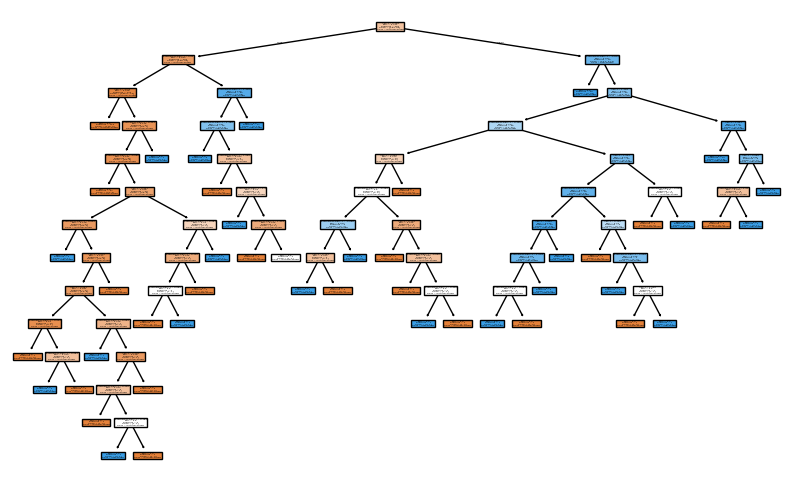

In [9]:
#Visualize the decision tree
plt.figure(figsize=(10,6))
plot_tree(clf, filled=True, feature_names=['Age', 'EstimatedSalary'], class_names=['Not Purchased', 'Purchased'])
plt.show()


In [10]:
tree_rules = export_text(clf, feature_names=['Age', 'EstimatedSalary'])
print(tree_rules)

|--- Age <= 0.46
|   |--- EstimatedSalary <= 0.61
|   |   |--- Age <= -0.11
|   |   |   |--- class: 0
|   |   |--- Age >  -0.11
|   |   |   |--- EstimatedSalary <= 0.40
|   |   |   |   |--- EstimatedSalary <= -0.07
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- EstimatedSalary >  -0.07
|   |   |   |   |   |--- Age <= 0.37
|   |   |   |   |   |   |--- EstimatedSalary <= 0.02
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- EstimatedSalary >  0.02
|   |   |   |   |   |   |   |--- Age <= 0.27
|   |   |   |   |   |   |   |   |--- Age <= 0.08
|   |   |   |   |   |   |   |   |   |--- EstimatedSalary <= 0.24
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- EstimatedSalary >  0.24
|   |   |   |   |   |   |   |   |   |   |--- EstimatedSalary <= 0.29
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- EstimatedSalary >  0.29
|   |   |   |   |   |   |   |   |   |   |   |-

In [11]:
#Hyperparameter tuning
params = {
    'max_depth': [1, 2, 3, 4, 5],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 4]
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params, cv=5)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)

# Evaluate the best model
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Best Accuracy:", accuracy_score(y_test, y_pred_best))


Best Params: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}
Best Accuracy: 0.925


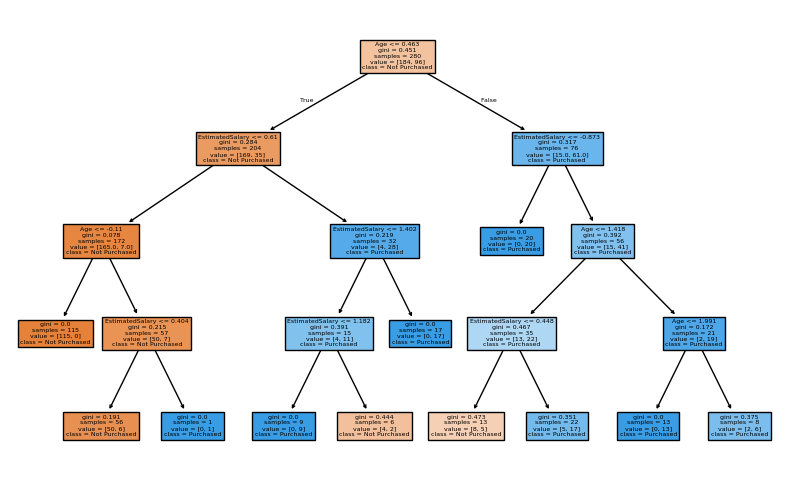

In [12]:
plt.figure(figsize=(10,6))
plot_tree(best_model, filled=True, feature_names=['Age', 'EstimatedSalary'], class_names=['Not Purchased', 'Purchased'])
plt.show()


### Pruning

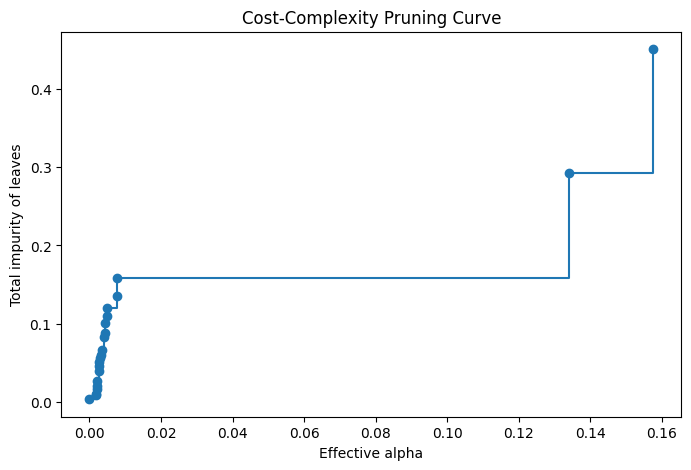

In [13]:
# Grow a full tree first
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get effective alphas and the corresponding total leaf impurities
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

# Plot to visualize
plt.figure(figsize=(8,5))
plt.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Total impurity of leaves")
plt.title("Cost-Complexity Pruning Curve")
plt.show()


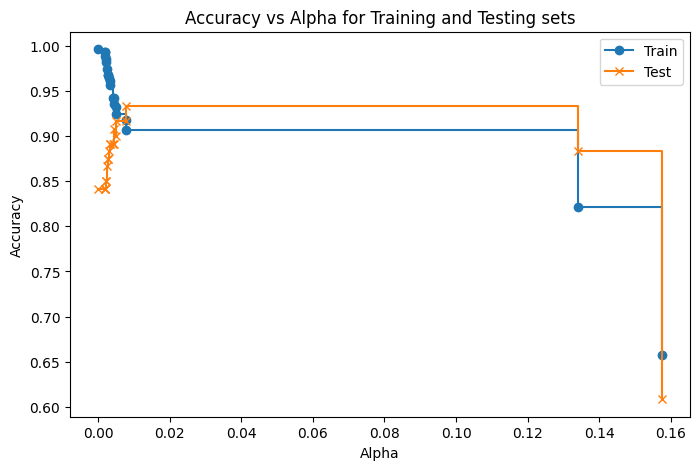

In [14]:
clfs = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Evaluate accuracy for each
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

# Plot train vs test accuracy
plt.figure(figsize=(8,5))
plt.plot(ccp_alphas, train_scores, marker='o', label='Train', drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='x', label='Test', drawstyle="steps-post")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Alpha for Training and Testing sets")
plt.legend()
plt.show()


In [15]:
best_alpha_index = np.argmax(test_scores)
best_alpha = ccp_alphas[best_alpha_index]
best_tree = clfs[best_alpha_index]

print("Best alpha:", best_alpha)
print("Test accuracy:", test_scores[best_alpha_index])


Best alpha: 0.007831881986017322
Test accuracy: 0.9333333333333333


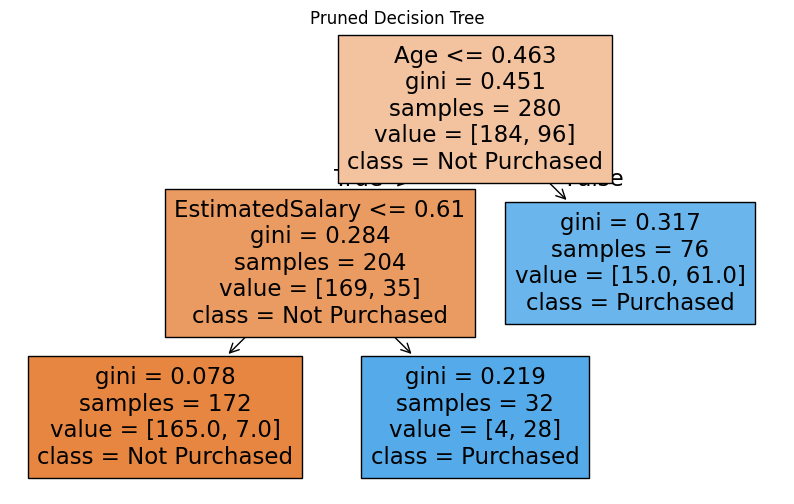

In [16]:
plt.figure(figsize=(10,6))
plot_tree(best_tree, filled=True, feature_names=['Age', 'EstimatedSalary'], class_names=['Not Purchased', 'Purchased'])
plt.title("Pruned Decision Tree")
plt.show()
